In [94]:
# autoreload for utils.py edits
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# helper library
from utils import (
    sweep_heads,
    sweep_mlp_layers,
    sweep_attention_head_positions,
    sweep_mlp_positions,
    plot_influence,
    plot_mlp_influence,
    plot_head_position_patch_heatmap,
    plot_mlp_position_patch_heatmap,
    get_attention_saliency,
    plot_timeseries_with_attention_overlay,
    get_probs,
    find_critical_patches,
    build_causal_graph,
    plot_causal_graph,
    patch_multiple_attention_heads_positions,
    patch_attention_head_at_position

)

from aeon.datasets import load_classification
from TSTtrainer import TimeSeriesTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and preprocessing JapaneseVowels data

In [95]:
X_train, y_train = load_classification("JapaneseVowels", split="train")
X_test, y_test = load_classification("JapaneseVowels", split="test")

# swap axes to (N, seq_len, 1) and convert to float32
def prep(X):
    X_np = X.astype(np.float32)
    return np.swapaxes(X_np, 1, 2)

X_test = torch.tensor(prep(X_test))
y_test = torch.tensor(y_test.astype(np.int64))

print("Test set:", X_test.shape, y_test.shape)

Test set: torch.Size([370, 25, 12]) torch.Size([370])


## Instantiate trained TST model

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = X_test.shape[1]
input_dim = X_test.shape[2]
num_classes = y_test.max() + 1

model = TimeSeriesTransformer(
    input_dim=input_dim,
    num_classes=num_classes,
    seq_len=seq_len,
    d_model=128,
    n_head=8,
    num_encoder_layers=3,
    dim_feedforward=256,
    dropout=0.1
).to(device)

num_layers = len(model.transformer_encoder.layers)

# LOAD CHECKPOINT
model.load_state_dict(torch.load("TST_japanesevowels.pth", map_location=device, weights_only=True))

<All keys matched successfully>

## Pick two test-set instances and examine

First, have a look at misclassified instances

In [97]:
model.eval()
misclassified = []
with torch.no_grad():
    for idx in range(len(X_test)):
        x = X_test[idx:idx+1].to(device)
        logits = model(x)
        probs  = torch.softmax(logits, dim=1)
        pred   = probs.argmax(dim=1).item()
        true   = y_test[idx].item()
        if pred != true:
            misclassified.append({
                "idx": idx,
                "true_label": true,
                "pred_label": pred,
                "P_true": probs[0, true].item(),
                "P_pred": probs[0, pred].item()
            })

df_mis = pd.DataFrame(misclassified).sort_values(by="P_true", ascending=True)
df_mis.reset_index(drop=True, inplace=True)
df_mis

,idx,true_label,pred_label,P_true,P_pred
0,36,2,8,0.006204,0.993416
1,170,4,2,0.034819,0.964566
2,46,2,3,0.087674,0.911487
3,44,2,3,0.107246,0.892122
4,31,2,9,0.113604,0.640457
5,114,3,8,0.184978,0.812860
6,20,1,6,0.365815,0.632164
7,127,3,8,0.375168,0.607927
8,1,1,6,0.408085,0.546106


In [98]:
idx_1 = 34
idx_2 = 44 # select a misclassified instance

x1 = X_test[[idx_1]].to(device)
y1 = y_test[[idx_1]].item()

x2 = X_test[[idx_2]].to(device)
y2 = y_test[[idx_2]].item()


print(f"Instance {idx_1} label={y1}, Instance {idx_2} label={y2}")

Instance 34 label=2, Instance 44 label=2


# Plot the raw time-series for each instance

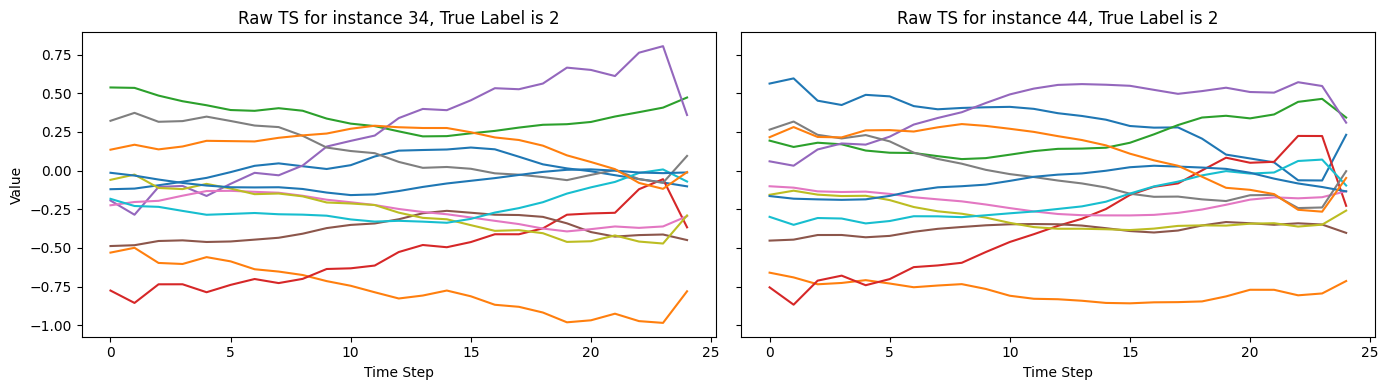

In [99]:
series_idx_1 = x1.cpu().numpy().squeeze()
series_idx_2 = x2.cpu().numpy().squeeze()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

axes[0].plot(x1.squeeze().cpu().numpy())
axes[0].set_title(f"Raw TS for instance {idx_1}, True Label is {y1}")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")

axes[1].plot(x2.squeeze().cpu().numpy())
axes[1].set_title(f"Raw TS for instance {idx_2}, True Label is {y2}")
axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

# Patching Experiment: ATTENTION HEAD PATCHING, LAYER-BY-LAYER

In [100]:

x1 = x1.squeeze(0)
x2 = x2.squeeze(0)

# PATCH EACH HEAD
patch_probs = sweep_heads(model, x1, x2, num_classes)
# DETERMINE BASELINE
baseline = get_probs(model, x2)

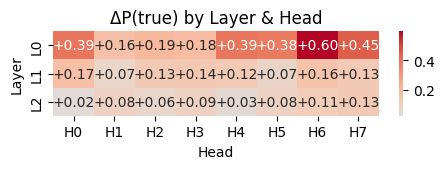

In [101]:

plot_influence(patch_probs, baseline, y2)

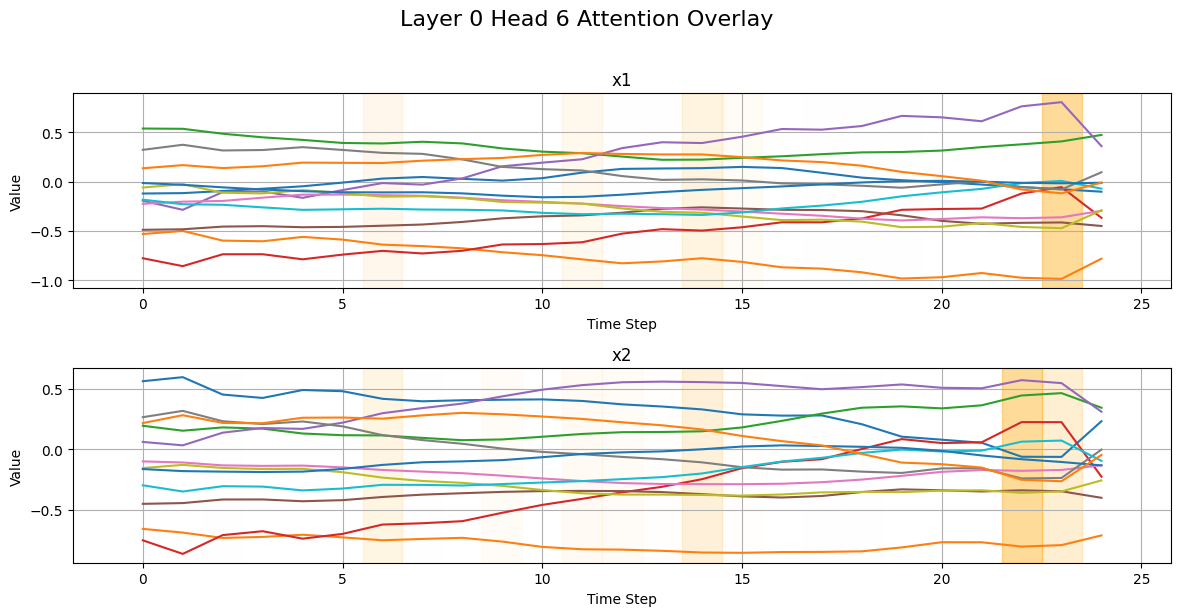

In [102]:
layer_idx = 0
head_idx = 6
instances = [x1, x2]
saliencies = [get_attention_saliency(model, inst, layer_idx, head_idx) for inst in instances]
labels = ["x1", "x2"]

plot_timeseries_with_attention_overlay(
    instances=[inst.squeeze(0) for inst in instances],
    saliencies=saliencies,
    labels=labels,
    title=f"Layer {layer_idx} Head {head_idx} Attention Overlay"
)


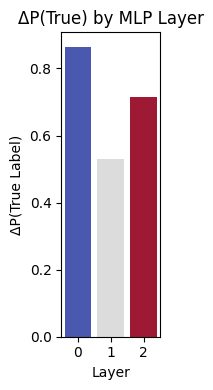

In [103]:
patch_probs_mlp = sweep_mlp_layers(model, x1, x2, num_classes=num_classes)
plot_mlp_influence(patch_probs_mlp, baseline, true_label=y2)

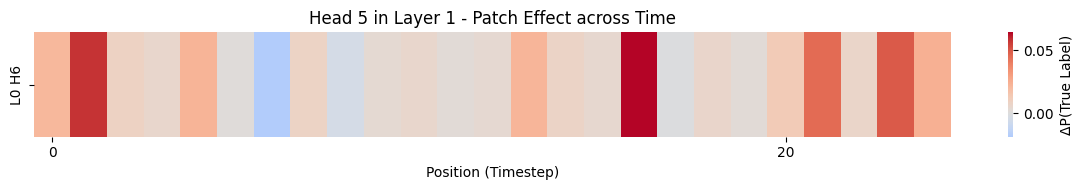

In [104]:
patch_probs_heads = sweep_attention_head_positions(model, x1, x2, num_layers, 8, seq_len, num_classes)
plot_head_position_patch_heatmap(
    patch_probs=patch_probs_heads,
    baseline_probs=baseline,
    true_label=y2,
    layer_idx=0,
    head_idx=6,
    title="Head 5 in Layer 1 - Patch Effect across Time"
)

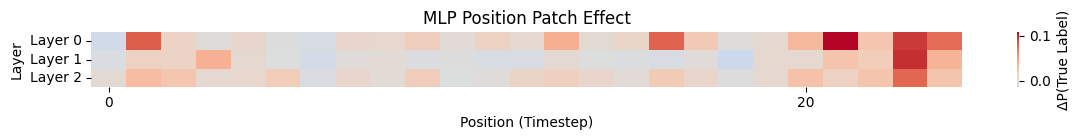

In [105]:
patch_probs = sweep_mlp_positions(model, x1, x2, num_layers, seq_len, num_classes)
plot_mlp_position_patch_heatmap(
    patch_probs, 
    baseline, 
    true_label=y2,
    title="MLP Position Patch Effect"
)

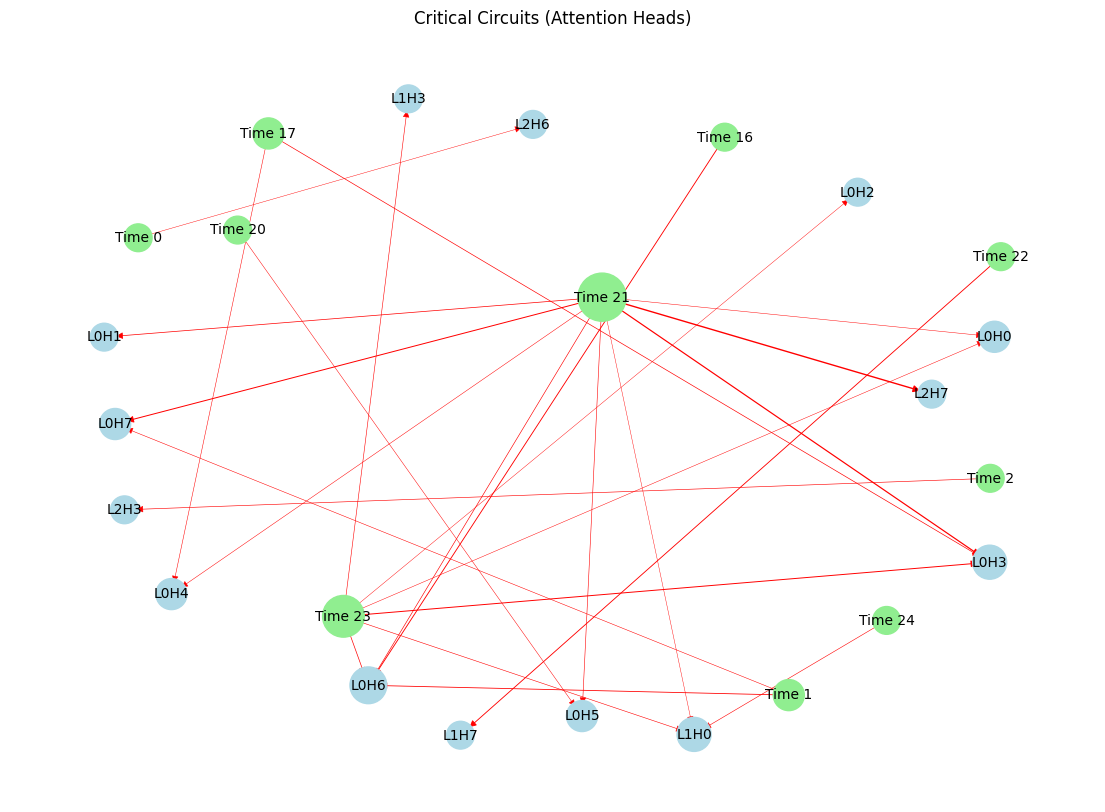

In [106]:
critical_patches = find_critical_patches(
    patch_probs_heads, 
    baseline,
    true_label=y2,
    threshold=0.03  # set as needed
)

# Build graph
G = build_causal_graph(critical_patches)

# Plot
plot_causal_graph(G, title="Critical Circuits (Attention Heads)")

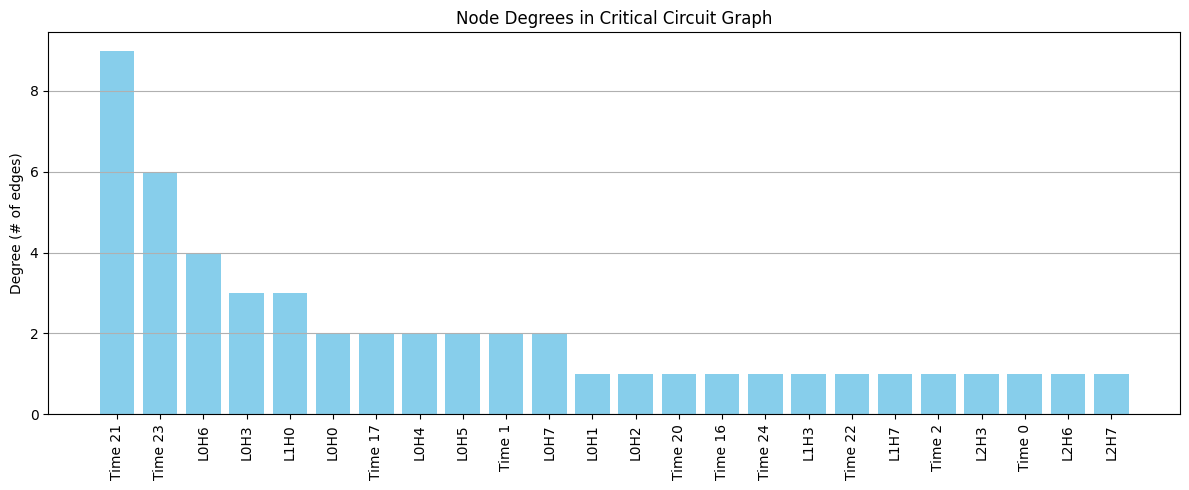

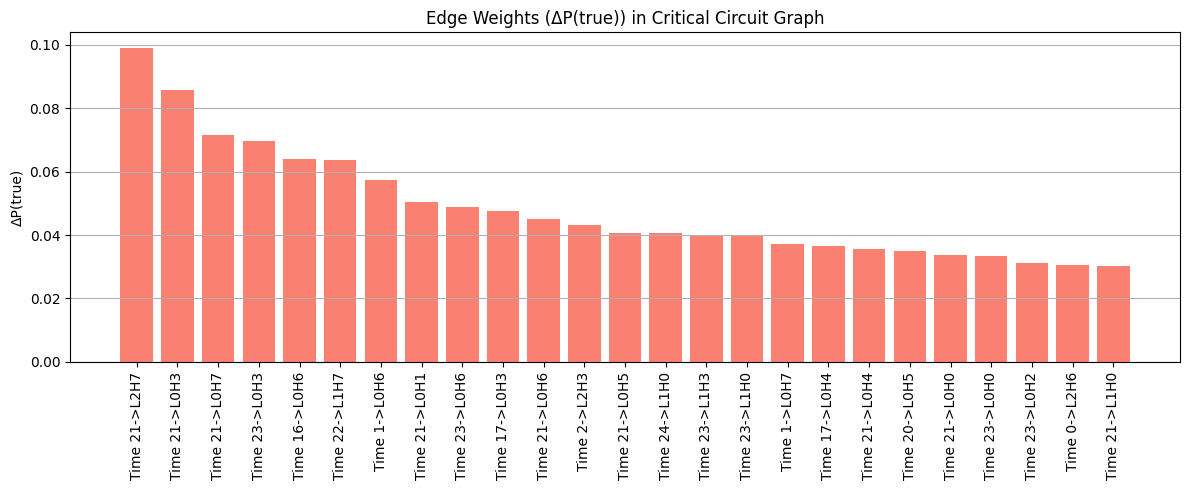

In [107]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_degrees]
values = [x[1] for x in sorted_degrees]

edges = list(G.edges(data=True))
sorted_edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)
sources = [f"{u}->{v}" for u,v,d in sorted_edges]
weights = [d['weight'] for u,v,d in sorted_edges]
    


plt.figure(figsize=(12, 5))
plt.bar(names, values, color="skyblue")
plt.xticks(rotation=90)
plt.title("Node Degrees in Critical Circuit Graph")
plt.ylabel("Degree (# of edges)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(sources, weights, color="salmon")
plt.xticks(rotation=90)
plt.title("Edge Weights (ΔP(true)) in Critical Circuit Graph")
plt.ylabel("ΔP(true)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [108]:

top_k = 10
critical_edges = sorted_edges[:top_k] 
logits_patched_multi = patch_multiple_attention_heads_positions(model, x1, x2, critical_edges)


probs_multi = torch.softmax(logits_patched_multi, dim=1)[0].detach().cpu().numpy()
delta_p_true_multi = probs_multi[y2] - baseline[y2]

print(f"ΔP(true) after multi-patching: {delta_p_true_multi:.4f}")

ΔP(true) after multi-patching: 0.5285


In [109]:
# Step 1: Get individual deltas
delta_individuals = []
for u, v, data in critical_edges:
    timestep = int(u.split()[1])
    layer = int(v[1])
    head = int(v[3])

    logits_patched = patch_attention_head_at_position(model, x1, x2, layer, head, timestep)
    probs_patched = torch.softmax(logits_patched, dim=1)[0].detach().cpu().numpy()
    delta = probs_patched[y2] - baseline[y2]
    delta_individuals.append(delta)

# Step 2: Get multi-patched delta
logits_patched_multi = patch_multiple_attention_heads_positions(model, x1, x2, critical_edges)
probs_multi = torch.softmax(logits_patched_multi, dim=1)[0].detach().cpu().numpy()
delta_combined = probs_multi[y2] - baseline[y2]

# Step 3: Compare
sum_individual = sum(delta_individuals)

print(f"Sum of individual effects: {sum_individual:.4f}")
print(f"Combined effect: {delta_combined:.4f}")

if delta_combined > sum_individual + 0.01:
    print("🟢 Synergy detected (Combined > Sum)")
elif delta_combined < sum_individual - 0.01:
    print("🔵 Interference detected (Combined < Sum)")
else:
    print("🟡 Additive behavior (Combined ≈ Sum)")


Sum of individual effects: 0.6583
Combined effect: 0.5285
🔵 Interference detected (Combined < Sum)
